# Internações por Doenças Respiratórias — Análise de Sazonalidade e Features
**Objetivo:** explorar a série diária de internações (RJ, 2012–2024), decompor comportamento temporal e gerar features para modelagem preditiva sem vazamento (look‑ahead).

## Visão geral das etapas
1. Carregamento e limpeza do dataset (data, ordenação, frequência diária).
2. Exploração: série temporal, PACF, perfis mensal/semana/estação, overlays por ano.
3. Decomposição STL para inspeção visual e cálculo de features (apenas histórico até t).

## Features geradas (sem vazamento)
- Lags PACF: lag_1 … lag_7
- Médias móveis trailing: ma_3, ma_7, ma_14
- Perfil mensal cíclico: mes_sin, mes_cos
- Perfil semanal:
  - dow (0=Seg … 6=Dom)
  - dow_sin, dow_cos (codificação cíclica semanal)
  - is_weekend (Sáb/Dom)
  - is_monday (flag segunda-feira)
- STL (APENAS 3 features, calculadas com janela apenas do passado):
  - stl365_seasonal      → valor da componente sazonal no dia t
  - stl365_resid_vol30   → volatilidade do resíduo (std dos últimos 30 dias)
  - stl365_season_amp    → amplitude sazonal local (max − min nos últimos ≈365 dias)

## Configurações e importações
Bibliotecas usadas e parâmetros gerais.

In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf as pacf_vals_fn
from statsmodels.tsa.seasonal import STL

## Consumindo o datasets (Internações)

**Objetivo:** Consumir o dataset com as quantidades de internações por doenças respiratórias da cidade do Rio de Janeiro de 2012 até 2024

In [5]:
url_internacoes = "https://raw.githubusercontent.com/EIC-BCC/25_2-QualiAr/refs/heads/main/data/DataSus/INTERNACOES_DOENCA_RESP_RJ.csv"

df_internacoes = pd.read_csv(url_internacoes, encoding="utf-8")

In [6]:
print("Dimensões:", df_internacoes.shape)

print("\nTipos:")
print(df_internacoes.dtypes)

print("\nAmostra:")
display(df_internacoes.head(10))

print("\nValores ausentes por coluna (top 20):")
na_counts = df_internacoes.isna().sum().sort_values(ascending=False)
na_perc   = (df_internacoes.isna().mean()*100).round(2).sort_values(ascending=False)
display(pd.DataFrame({"NA_count": na_counts, "NA_%": na_perc}).head(20))

Dimensões: (4748, 2)

Tipos:
data_dia           object
num_internacoes     int64
dtype: object

Amostra:


,data_dia,num_internacoes
0,2012-01-01,507
1,2012-01-02,728
2,2012-01-03,429
3,2012-01-04,416
4,2012-01-05,403
5,2012-01-06,520
6,2012-01-07,299
7,2012-01-08,390
8,2012-01-09,442
9,2012-01-10,546



Valores ausentes por coluna (top 20):


,NA_count,NA_%
data_dia,0,0.0
num_internacoes,0,0.0


## 1. Série Temporal das Internações

Visualização da evolução diária no período analisado.

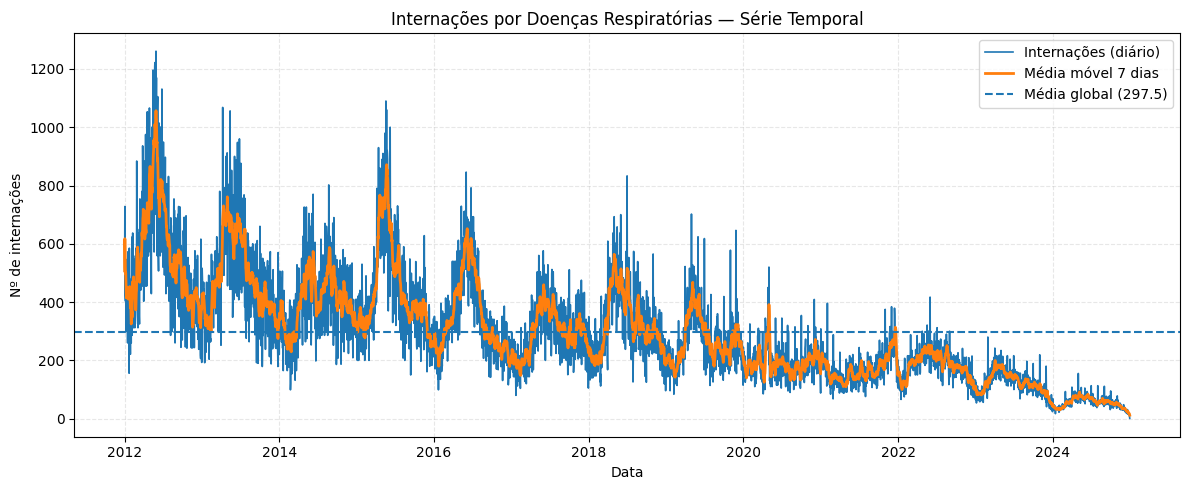

In [7]:
df = df_internacoes.copy()

# Garantir tipo datetime e ordenação temporal
df['data_dia'] = pd.to_datetime(df['data_dia'], format='%Y-%m-%d', errors='raise')
df = df.sort_values('data_dia')

# Série com índice de data
s = df.set_index('data_dia')['num_internacoes'].astype(float)

# Média global e média móvel (janela de 7 dias)
media_global = s.mean()
mm7 = s.rolling(window=7, min_periods=1).mean()

# --- Gráfico ---
plt.figure(figsize=(12, 5))
plt.plot(s.index, s.values, linewidth=1.2, label='Internações (diário)')
plt.plot(mm7.index, mm7.values, linewidth=2, label='Média móvel 7 dias')
plt.axhline(media_global, linestyle='--', linewidth=1.5, label=f'Média global ({media_global:.1f})')

plt.title('Internações por Doenças Respiratórias — Série Temporal')
plt.xlabel('Data')
plt.ylabel('Nº de internações')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

**Leitura geral**
- **Tendência:** há uma **queda de longo prazo** no nível médio ao longo dos anos. A linha tracejada indica **média global ≈ 297,5** internações/dia; os primeiros anos ficam **acima** dessa média e os anos mais recentes, **abaixo**.
- **Sazonalidade:** observam-se **ondulações recorrentes** ao longo do ano. A **MM(7 dias)** evidencia ciclos e suaviza o forte ruído diário.
- **Volatilidade:** a **amplitude das flutuações diminui** conforme o nível cai (sinal de **heterocedasticidade**). Isso sugere que transformações como **log1p** podem estabilizar a variância para alguns modelos.
- **Ruído e outliers:** existem picos pontuais bem acima da MM(7), possivelmente eventos específicos (epidemias locais, surtos, mudanças operacionais).

**Implicações para modelagem**
- A série é **não-estacionária** (tendência + sazonalidade)
- Se o foco for previsão operacional de curto prazo, a **MM(7)** (ou 14) já fornece um **sinal mais estável**; para longo prazo, decompor a série (ex.: **STL**) ajuda a separar **tendência** e **sazonalidade**.


## 2. PACF (Partial Autocorrelation Function) das Internações Diárias

A PACF ajuda a identificar a **ordem de defasagens** com dependência parcial significativa.

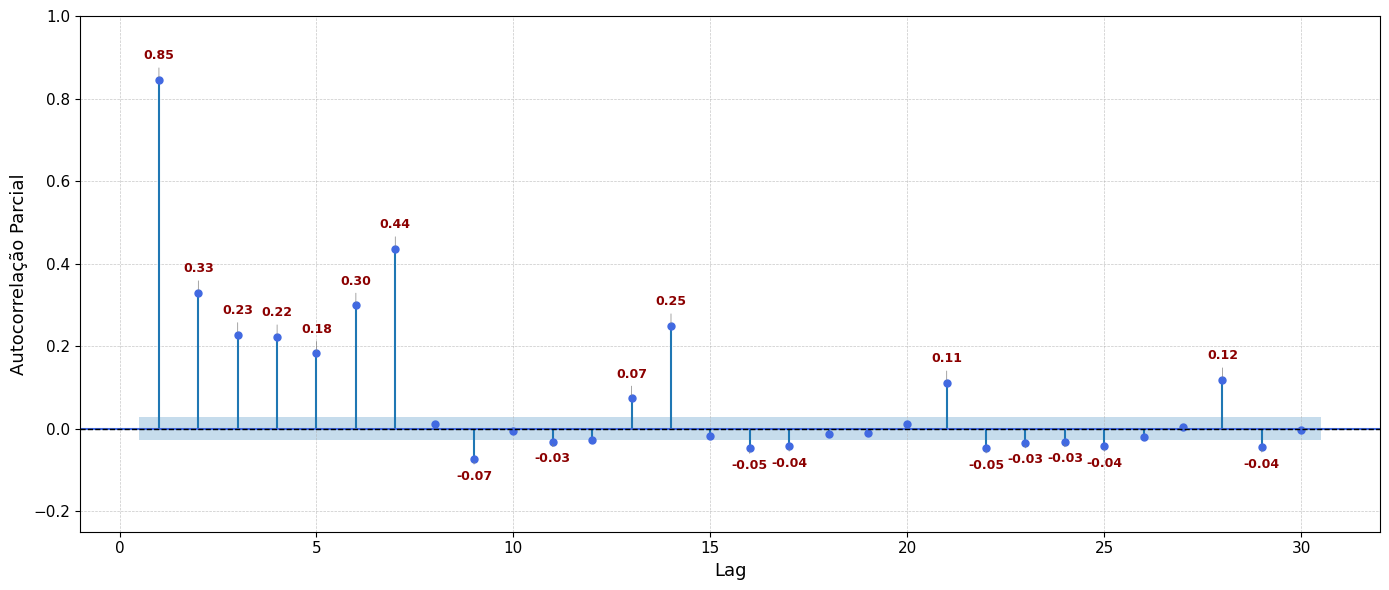

In [8]:
serie = pd.to_numeric(df["num_internacoes"], errors="coerce").dropna()

max_lags = 30
lags = int(min(max_lags, max(1, len(serie) - 1)))

fig, ax = plt.subplots(figsize=(14, 6))

try:
    plot_pacf(
        serie,
        lags=lags,
        method='ywm',
        ax=ax,
        color='royalblue',     
        zero=False,
        alpha=0.05,
    )
except TypeError:
    plot_pacf(
        serie,
        lags=lags,
        method='ywm',
        ax=ax,
        zero=False,
        alpha=0.05,
        use_vlines=True,
        vlines_kwargs={"colors": "royalblue"},
        marker='o',
        markersize=4,
    )

ax.set_ylim(-0.25, 1)
ax.axhline(0, linestyle='--', color='black', linewidth=1)
ax.set_title("", fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel("Lag", fontsize=13)
ax.set_ylabel("Autocorrelação Parcial", fontsize=13)
ax.tick_params(axis='both', labelsize=11)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Valores da PACF para anotar e intervalo normal aproximado
pacf_vals = pacf_vals_fn(serie, nlags=lags, method='ywm')
conf_interval = 1.96 / np.sqrt(len(serie))

for i, val in enumerate(pacf_vals[1:], start=1):
    if abs(val) > conf_interval:
        ax.annotate(
            f'{val:.2f}',
            xy=(i, val),
            xytext=(i, val + 0.05 * np.sign(val)),
            ha='center',
            fontsize=9,
            color='darkred',
            fontweight='bold',
            arrowprops=dict(arrowstyle='-', lw=0.5, color='gray')
        )

plt.tight_layout()
plt.show()

**Leituras principais**
- **Lag 1 muito alto (~0,85):** forte **persistência diária** → o valor de hoje explica boa parte de amanhã. Indica necessidade de **diferenciação** (ou remoção de tendência) e/ou um **termo AR(1)**.
- **Lags 2–6 ainda positivos (≈0,18–0,33):** inércia de curto prazo além do primeiro dia. Sugere **ordem AR > 1** ou combinação AR/MA após tratar tendência.
- **Lag 7 destacado (~0,44)** e **múltiplos 14 (~0,25), 21 (~0,11), 28 (~0,12):** padrão claro de **sazonalidade semanal** (ciclos de 7 dias).
- Pequenos **valores negativos** entre 9–12 e em alguns lags médios: possível **overshoot/reversão** após o ciclo semanal.
- Queda gradual da magnitude após 14–21: dependência sazonal **não muito longa**, concentrada em poucos ciclos semanais.

**Implicações para modelagem**
- Trabalhar com **diferenciação** (d=1) e testar **diferença sazonal de 7 dias** (D=1) caso a ACF também mostre picos sazonais.
- Candidatos SARIMA:  
  - **(p,d,q)×(P,D,Q)\_s** com **s=7**, por exemplo:  
    - (1–3, 1, 0–2) × (1–2, 0–1, 0–1)\_7  
  - Ajustar p pelo corte/decay da PACF não sazonal; ajustar P pela força em 7 e 14.
- Se optar por decompor antes (STL), modelar apenas a **componente residual** reduz a necessidade de ordens altas.

## 3. Correlação entre Médias Móveis

Comparamos a série original e suas versões suavizadas por **médias móveis** (janelas: 3, 7, 14, 21, 30, 60 dias).  
A tabela e o mapa de calor ajudam a entender como diferentes escalas de suavização se relacionam.

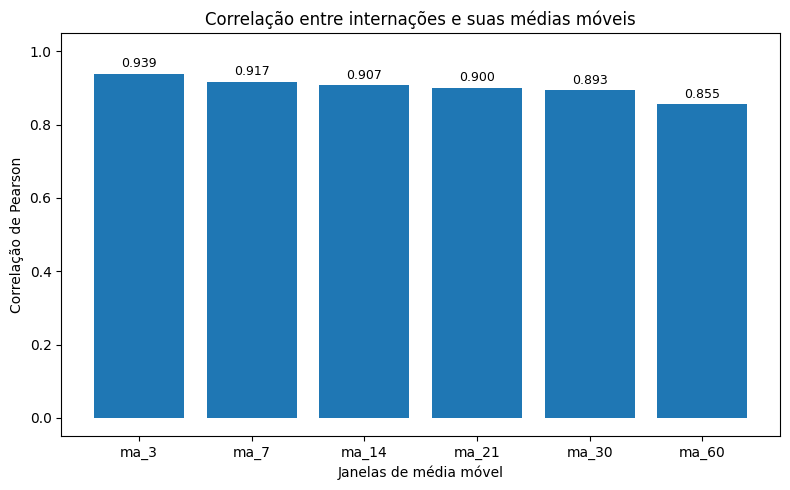

In [9]:
import matplotlib.pyplot as plt

s = df.set_index('data_dia')['num_internacoes'].astype(float)

# --- Médias móveis ---
ROLL_WINDOWS = [3, 7, 14, 21, 30, 60]

df_roll = pd.DataFrame({'y': s})
for w in ROLL_WINDOWS:
    df_roll[f'ma_{w}'] = s.rolling(window=w, min_periods=max(1, w//2)).mean()

# --- Correlações ---
corr_all = df_roll.corr(method='pearson')

# seleciona apenas as correlações de y com as médias móveis
ma_cols = [f'ma_{w}' for w in ROLL_WINDOWS]
corr_ma = corr_all.loc['y', ma_cols]

# --- Gráfico de barras ---
fig, ax = plt.subplots(figsize=(8, 5))

bars = ax.bar(ma_cols, corr_ma)

ax.set_title('Correlação entre internações e suas médias móveis')
ax.set_ylabel('Correlação de Pearson')
ax.set_xlabel('Janelas de média móvel')

# Limite do eixo Y para dar espaço pros rótulos
ax.set_ylim(min(0, corr_ma.min()) - 0.05, 1.05)

# Adiciona o valor da correlação em cima de cada barra
for i, v in enumerate(corr_ma):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

**Leituras principais**
- **Alta correlação com a série original em janelas curtas:** `ma_3 (0,939)` > `ma_7 (0,917)` > `ma_14 (0,907)`.  
  - Quanto **menor** a janela, **maior** a aderência ao sinal diário (menos suavização e menor atraso).
- **Suavizações longas perdem aderência ao dia a dia:** correlação de `y` cai gradualmente até `ma_60 (0,855)`.  
  - Isso é esperado: janelas maiores removem mais ruído, **atenuam picos** e **introduzem atraso**.
- **As MAs entre si são quase colineares** nas janelas médias/longas:  
  `ma_14–ma_21 (0,996)`, `ma_21–ma_30 (0,996)`, `ma_30–ma_60 (0,982)`.  
  - Indica que, a partir de ~14 dias, todas capturam **a mesma tendência de médio/longo prazo** com pequenas diferenças.

**Interpretação operacional**
- **Curto prazo / responsividade:** use `MA(3)` ou `MA(7)` para monitoramento diário/decisões rápidas (maior correlação com `y`).
- **Médio prazo / tendência:** `MA(14–30)` entrega um **sinal estável** sem perder demais a dinâmica; diferenças entre 14, 21 e 30 são **marginais**.
- **Longo prazo / suavização forte:** `MA(60)` é útil para análises estruturais (nível de base), mas reage lentamente a mudanças.


## 4. Perfil Mensal das Internações

Média mensal ao longo dos anos para evidenciar **sazonalidade anual**.

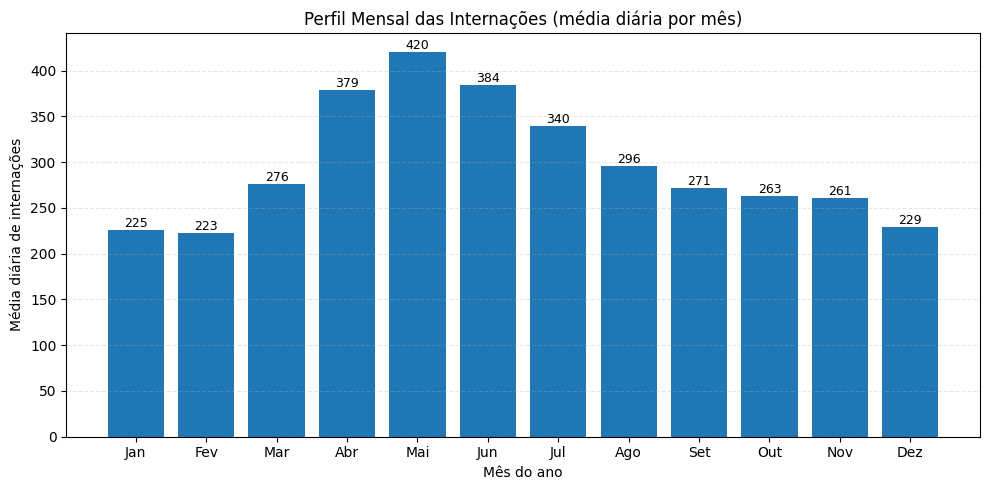

In [10]:
s = df.set_index('data_dia')['num_internacoes'].astype(float)

# --- Perfil mensal: média diária por mês (agregando todos os anos) ---
monthly_mean = s.groupby(s.index.month).mean()

# Rótulos dos meses em PT-BR
meses = {1:'Jan',2:'Fev',3:'Mar',4:'Abr',5:'Mai',6:'Jun',
         7:'Jul',8:'Ago',9:'Set',10:'Out',11:'Nov',12:'Dez'}
x_labels = [meses[m] for m in range(1, 13)]
vals = [monthly_mean.get(m, np.nan) for m in range(1, 13)]

# --- Gráfico ---
plt.figure(figsize=(10, 5))
bars = plt.bar(x_labels, vals)
plt.title('Perfil Mensal das Internações (média diária por mês)')
plt.xlabel('Mês do ano')
plt.ylabel('Média diária de internações')
plt.grid(True, axis='y', linestyle='--', alpha=0.3)

# Anota valores nas barras
for rect, v in zip(bars, vals):
    if not np.isnan(v):
        plt.text(rect.get_x() + rect.get_width()/2, rect.get_height(),
                 f'{v:.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

**Padrão sazonal anual**
- **Pico pronunciado no outono**, com **maio** no topo (**≈420**). Abril (**≈379**) e junho (**≈384**) também elevados.
- **Início de ano é o vale**: **jan–fev** apresentam os menores níveis (**≈225–223**), com **dez** também baixo (**≈229**).
- Trajetória típica: **sobe de fev → mar → abr → maio (pico)** e depois **declina gradualmente** de jun → nov.
- **Amplitude sazonal alta:** pico/vale ≈ **420/223 ≈ 1,88**. Ou seja, maio tem ~**88%** mais internações que fevereiro.

**Leituras por estação (hemisfério sul)**
- **Verão (dez–fev):** patamar **baixo**.
- **Outono (mar–mai):** **máximos** do ano, culminando em **maio**.
- **Inverno (jun–ago):** ainda **elevado**, porém **em queda** ao longo da estação.
- **Primavera (set–nov):** níveis **intermediários/baixos**, próximos ao piso anual.

**Implicações para modelagem**
- A sazonalidade **anual é forte**. Em modelos:
  - Incluir **dummies de mês**
- Para dashboards/monitoramento, comparar meses **com sua própria linha de base sazonal** (ex.: maio vs média de maios) evita alarmes por efeito sazonal esperado.


## 5. Perfil Semanal das Internações

Média por dia da semana para identificar rotina operacional e sazonalidade de **7 dias**.

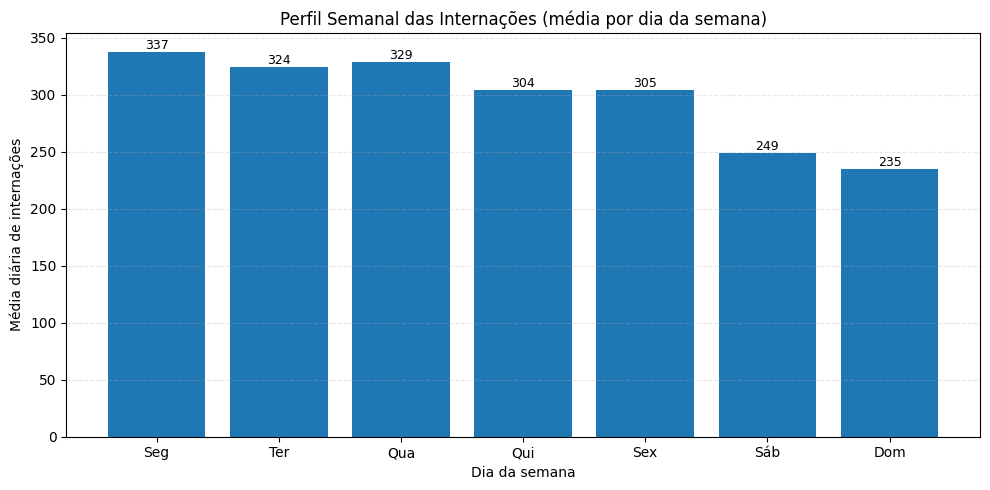

In [11]:
s = df.set_index('data_dia')['num_internacoes'].astype(float)

# --- Perfil semanal: média por dia da semana (0=Seg, 6=Dom) ---
weekday_mean = s.groupby(s.index.dayofweek).mean()

dias = {0:'Seg', 1:'Ter', 2:'Qua', 3:'Qui', 4:'Sex', 5:'Sáb', 6:'Dom'}
x_labels = [dias[d] for d in range(7)]
vals = [weekday_mean.get(d, np.nan) for d in range(7)]

# --- Gráfico ---
plt.figure(figsize=(10, 5))
bars = plt.bar(x_labels, vals)
plt.title('Perfil Semanal das Internações (média por dia da semana)')
plt.xlabel('Dia da semana')
plt.ylabel('Média diária de internações')
plt.grid(True, axis='y', linestyle='--', alpha=0.3)

# Anota valores nas barras
for rect, v in zip(bars, vals):
    if not np.isnan(v):
        plt.text(rect.get_x() + rect.get_width()/2, rect.get_height(),
            f'{v:.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

**Padrão semanal claro**
- **Dias úteis > fim de semana.** Média de **Seg–Sex ≈ 320** versus **Sáb–Dom ≈ 242** → **~24% menor** no fim de semana.
- **Segunda é o pico** (**337**), possivelmente refletindo **represamento de atendimentos** do fim de semana e/ou agenda eletiva.
- **Ter–Qua** mantêm patamar alto (**324–329**).  
- **Qui–Sex** caem um pouco (**304–305**) — tendência de redução ao final da semana.
- **Sábado (249) e Domingo (235)** são os **vales**; diferença **Seg vs Dom ≈ 102** internações.

**Interpretações operacionais**
- Padrão compatível com **calendário hospitalar**: menor volume de admissões eletivas no fim de semana e retomada na **segunda**.
- Parte da variação pode refletir **processos administrativos/triagem** e **disponibilidade de equipe**.

**Implicações para modelagem**
- Incluir **sazonalidade semanal (s=7)**:  
- Tratar **efeitos de fim de semana** explicitamente (dummy `is_weekend`) e, se necessário, **variância distinta** para Sáb/Dom (heterocedasticidade).

## 6. Decomposição STL (Tendência, Sazonalidade, Resíduo)

Separa a série em **Tendência**, **Sazonalidade** (período definido) e **Resíduo**.

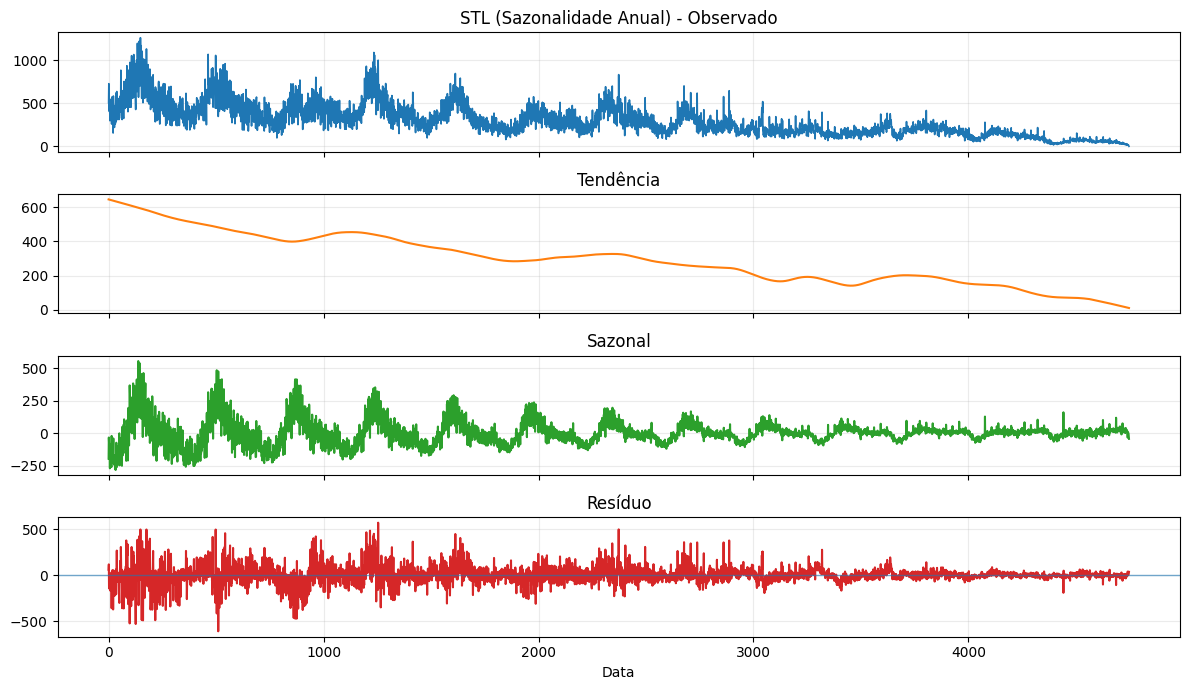

In [12]:
def plot_stl_decomposition(
    df_daily: pd.DataFrame,
    value_col: str = "num_internacoes",
    period: int = 365,
    loess: int = 13,
    log_transform: bool = False,
    figsize=(12,7),
    title_prefix: str = "STL (Sazonalidade Anual)"
) -> None:
    """
    Aplica STL para decompor a série em Observado, Tendência, Sazonal, Resíduo.

    Observações:
    - 'period' em dias. Para sazonalidade anual use 365 (ou 365/366).
    Para sazonalidade semanal, use 7.
    - Se a variância cresce com o nível da série, pode-se usar log_transform=True.

    Parâmetros
    ----------
    df_daily : DataFrame diário preparado (index datetime com frequência 'D')
    value_col : coluna do valor
    period : período da sazonalidade (ex.: 365 para anual, 7 para semanal)
    loess : tamanho base da janela LOESS usada pela STL (ajusta 'seasonal' e 'trend')
    log_transform : se True, aplica log1p antes da decomposição
    figsize : tamanho da figura
    title_prefix : prefixo do título
    """
    y = df_daily[value_col].copy().astype(float)
    if log_transform:
        y = np.log1p(y)

    # Ajustes de janelas (STL exige janelas ímpares e >= 7)
    period = int(period)
    seas_win = int(loess)
    if seas_win < 7:
        seas_win = 7
    if seas_win % 2 == 0:
        seas_win += 1

    # Janela de tendência maior que o período (e ímpar)
    trend_win = period + 2
    if trend_win % 2 == 0:
        trend_win += 1

    stl_res = STL(y, period=period, seasonal=seas_win, trend=trend_win, robust=True).fit()

    obs = y
    trend = stl_res.trend
    seas = stl_res.seasonal
    resid = stl_res.resid

    fig, axes = plt.subplots(4, 1, figsize=figsize, sharex=True)

    axes[0].plot(obs, lw=1.2)
    axes[0].set_title(f"{title_prefix} - Observado")

    axes[1].plot(trend, color="C1")
    axes[1].set_title("Tendência")

    axes[2].plot(seas, color="C2")
    axes[2].set_title("Sazonal")

    axes[3].plot(resid, color="C3")
    axes[3].axhline(0, lw=1, alpha=0.6)
    axes[3].set_title("Resíduo")

    for ax in axes:
        ax.grid(True, alpha=0.25)
    axes[-1].set_xlabel("Data")

    fig.tight_layout()
    plt.show()


# --- Exemplo de uso ---
# Sazonalidade anual (period=365)
plot_stl_decomposition(df_internacoes, period=365, loess=13, title_prefix="STL (Sazonalidade Anual)")

**Leituras principais**
- **Tendência:** queda de longo prazo bem marcada. Há pequenos platôs/recuos intermediários, mas a trajetória geral é **descendente**, chegando aos **menores níveis no final da série**.
- **Sazonalidade (period=365):** padrão **anual** claro e coerente com o perfil mensal/estações (picos no outono, sobretudo out/maio; vales em verão).  
  A **amplitude sazonal diminui** ao longo do tempo, acompanhando a redução do nível.
- **Resíduo:** centrado em zero, com **heterocedasticidade** (maior dispersão nos primeiros anos e encolhimento recente). Existem **picos isolados** (choques/eventos) não explicados por tendência/sazonalidade.

**Implicações para modelagem**
- O componente observado é **não-estacionário**; remover tendência e sazonalidade (via STL, dummies de mês ou termos de **Fourier**) antes de modelar melhora o ajuste.
- A queda na variância sugere avaliar **transformação log1p** para estabilizar ruído, principalmente se a meta for previsão de curto prazo.

**Validações/diagnósticos recomendados**
- Quantificar forças:  
  - **Força sazonal**: \( F_s = \max\{0,\,1 - \frac{\operatorname{Var}(resid)}{\operatorname{Var}(seasonal+resid)}\} \)  
  - **Força da tendência**: \( F_t = \max\{0,\,1 - \frac{\operatorname{Var}(resid)}{\operatorname{Var}(trend+resid)}\} \)


## 7. Perfil por estação do ano

C:\Users\jhter\AppData\Local\Temp\ipykernel_29120\2509609210.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  _ = plt.boxplot(grupos, labels=ordem, showmeans=True,


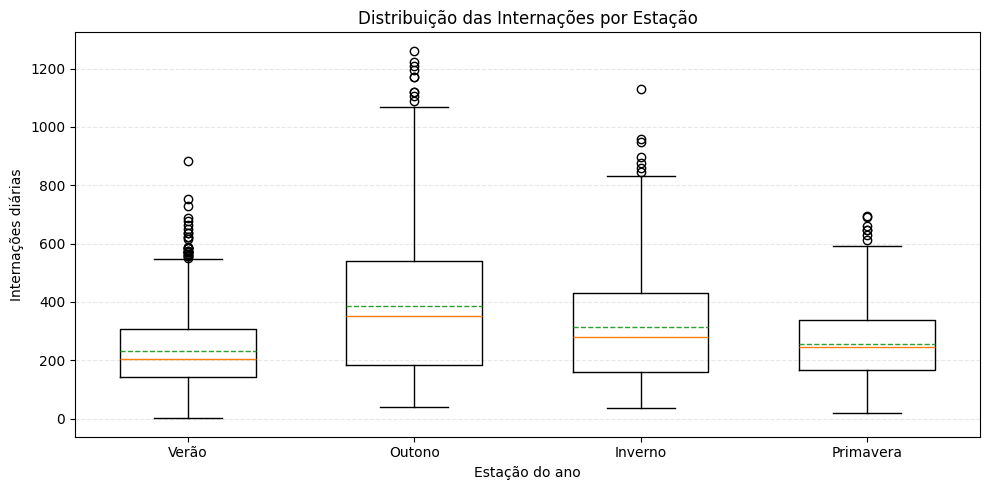

C:\Users\jhter\AppData\Local\Temp\ipykernel_29120\2509609210.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = (df_daily.groupby('estacao')['num_internacoes']


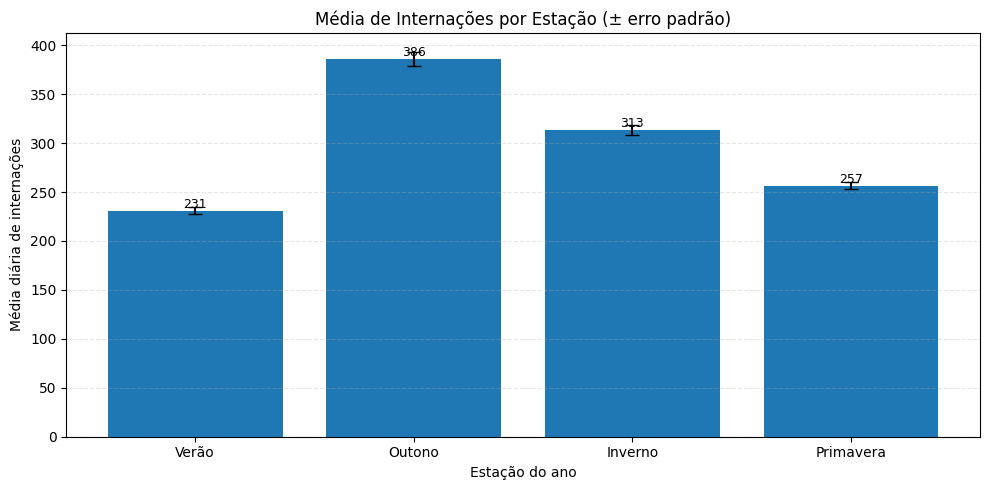

C:\Users\jhter\AppData\Local\Temp\ipykernel_29120\2509609210.py:85: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  .pivot_table(index='ano', columns='estacao',


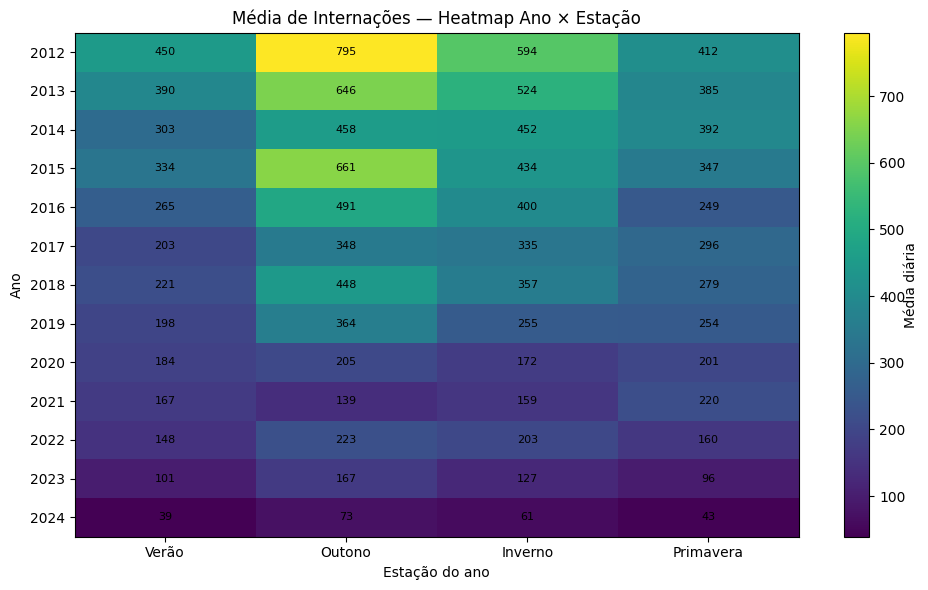

In [13]:
def preparar_df_diario_com_estacao(df_internacoes: pd.DataFrame) -> pd.DataFrame:
    df = df_internacoes.copy()
    df['data_dia'] = pd.to_datetime(df['data_dia'], format='%Y-%m-%d', errors='raise')
    df = df.sort_values('data_dia')

    # Índice diário contínuo
    df = df.set_index('data_dia').asfreq('D')
    df['num_internacoes'] = df['num_internacoes'].astype(float)

    # Se houver lacunas, interpolar suavemente
    if df['num_internacoes'].isna().any():
        df['num_internacoes'] = df['num_internacoes'].interpolate(limit_direction='both')

    # Estações (hemisfério sul) com seus marcos:
    # Verão: 21/12 – 20/03
    # Outono: 21/03 – 20/06
    # Inverno: 21/06 – 22/09
    # Primavera: 22/09 – 21/12
    m = df.index.month
    d = df.index.day

    verao     = ((m == 12) & (d >= 21)) | (m == 1) | (m == 2) | ((m == 3) & (d <= 20))
    outono    = ((m == 3) & (d >= 21)) | (m == 4) | (m == 5) | ((m == 6) & (d <= 20))
    inverno   = ((m == 6) & (d >= 21)) | (m == 7) | (m == 8) | ((m == 9) & (d <= 22))
    primavera = ((m == 9) & (d >= 22)) | (m == 10) | (m == 11) | ((m == 12) & (d <= 20))

    # Resultado de estação (ndarray) -> Categorical (pandas)
    ordem = ['Verão', 'Outono', 'Inverno', 'Primavera']
    escolhas = np.select(
        [verao, outono, inverno, primavera],
        ordem,
        default='Primavera'  # fallback por segurança
    )
    df['estacao'] = pd.Categorical(escolhas, categories=ordem, ordered=True)

    df['ano'] = df.index.year
    return df

# -----------------------------
# 1) Boxplot por estação
# -----------------------------
def plot_boxplot_por_estacao(df_daily: pd.DataFrame):
    ordem = ['Verão', 'Outono', 'Inverno', 'Primavera']
    grupos = [df_daily.loc[df_daily['estacao'] == est, 'num_internacoes'].dropna().values for est in ordem]

    plt.figure(figsize=(10, 5))
    _ = plt.boxplot(grupos, labels=ordem, showmeans=True,
                    meanline=True, whis=1.5, widths=0.6)
    plt.title('Distribuição das Internações por Estação')
    plt.xlabel('Estação do ano')
    plt.ylabel('Internações diárias')
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# -----------------------------
# 2) Média por estação (com erro padrão)
# -----------------------------
def plot_media_por_estacao(df_daily: pd.DataFrame):
    ordem = ['Verão', 'Outono', 'Inverno', 'Primavera']
    agg = (df_daily.groupby('estacao')['num_internacoes']
                  .agg(['mean','std','count'])
                  .reindex(ordem))
    agg['sem'] = agg['std'] / np.sqrt(agg['count'])

    plt.figure(figsize=(10, 5))
    plt.bar(agg.index, agg['mean'], yerr=agg['sem'], capsize=5)
    plt.title('Média de Internações por Estação (± erro padrão)')
    plt.xlabel('Estação do ano')
    plt.ylabel('Média diária de internações')
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)

    # anotar valores
    for i, v in enumerate(agg['mean']):
        plt.text(i, v, f'{v:.0f}', ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()

# -----------------------------
# 3) Heatmap Ano × Estação
# -----------------------------
def plot_heatmap_ano_estacao(df_daily: pd.DataFrame):
    ordem = ['Verão', 'Outono', 'Inverno', 'Primavera']
    tabela = (df_daily
              .pivot_table(index='ano', columns='estacao',
                           values='num_internacoes', aggfunc='mean')
              .reindex(columns=ordem))

    fig = plt.figure(figsize=(10, 6))
    im = plt.imshow(tabela.values, aspect='auto')
    plt.title('Média de Internações — Heatmap Ano × Estação')
    plt.xlabel('Estação do ano')
    plt.ylabel('Ano')
    plt.xticks(ticks=np.arange(len(ordem)), labels=ordem)
    plt.yticks(ticks=np.arange(len(tabela.index)), labels=tabela.index)
    cbar = plt.colorbar(im)
    cbar.ax.set_ylabel('Média diária', rotation=90, va='center')

    # anotar valores nas células (opcional)
    for i in range(tabela.shape[0]):
        for j in range(tabela.shape[1]):
            val = tabela.values[i, j]
            if not np.isnan(val):
                plt.text(j, i, f'{val:.0f}', ha='center', va='center', fontsize=8, color='black')

    plt.tight_layout()
    plt.show()

# -----------------------------
# Uso
# -----------------------------
df_daily = preparar_df_diario_com_estacao(df_internacoes)
plot_boxplot_por_estacao(df_daily)
plot_media_por_estacao(df_daily)
plot_heatmap_ano_estacao(df_daily)

## 8. Overlay por ano

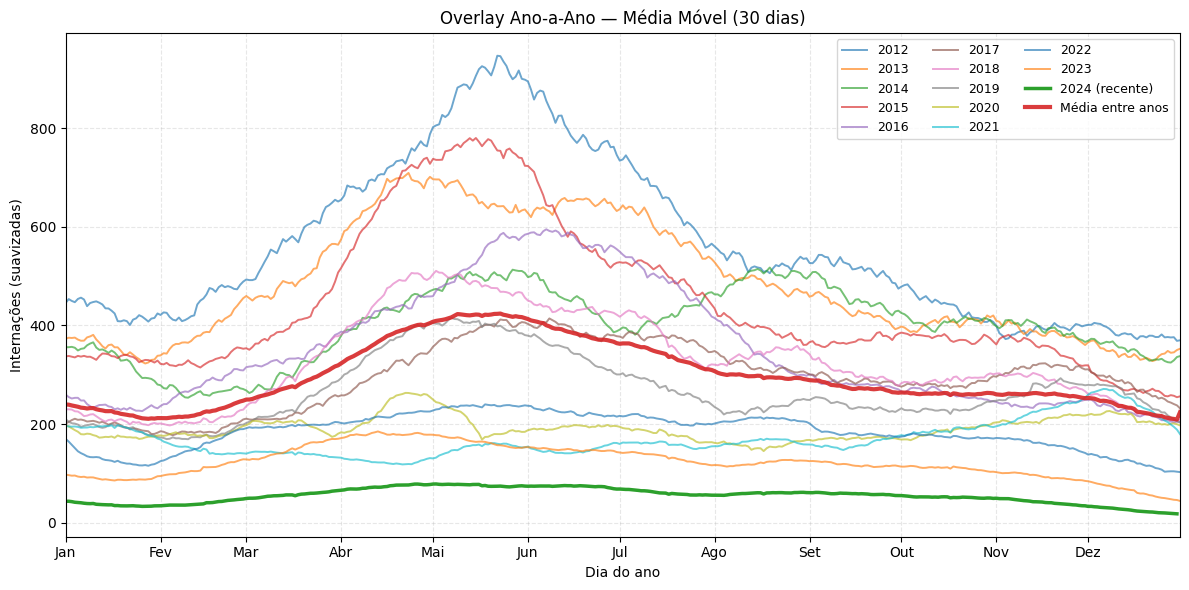

In [14]:
def plot_overlay_ano_a_ano(
    df_internacoes: pd.DataFrame,
    window: int = 30,
    drop_feb29: bool = True,
    scale_per_year: bool = False,
    center: bool = True,
) -> None:
    """
    Overlay ano-a-ano com média móvel suavizada.

    Parâmetros
    ----------
    df_internacoes : DataFrame com colunas ['data_dia', 'num_internacoes']
    window         : tamanho da janela da média móvel (ex.: 30)
    drop_feb29     : se True, remove 29/fev p/ alinhar anos em 365 dias
    scale_per_year : se True, padroniza cada ano (z-score) p/ comparar formas
    center         : se True, usa média móvel centrada
    """
    # --- preparar série diária contínua ---
    df = df_internacoes.copy()
    df['data_dia'] = pd.to_datetime(df['data_dia'], format='%Y-%m-%d', errors='raise')
    df = df.sort_values('data_dia')
    s = (df.set_index('data_dia')['num_internacoes']
        .astype(float)
        .asfreq('D'))

    if s.isna().any():
        s = s.interpolate(limit_direction='both')

    mm = s.rolling(window=window, min_periods=max(1, window//2), center=center).mean()

    tmp = mm.to_frame('y').dropna()
    idx = tmp.index
    tmp['year'] = idx.year
    tmp['month'] = idx.month
    tmp['day'] = idx.day
    tmp['doy'] = idx.dayofyear

    if drop_feb29:
        tmp = tmp[~((tmp['month'] == 2) & (tmp['day'] == 29))]

        ref_year = 2021
        ref_dates = pd.to_datetime(
            [f"{ref_year}-{m:02d}-{d:02d}" for m, d in zip(tmp['month'], tmp['day'])],
            format="%Y-%m-%d"
        )
        tmp['doy'] = ref_dates.dayofyear

    if scale_per_year:
        tmp['y'] = tmp.groupby('year')['y'].transform(lambda x: (x - x.mean()) / (x.std(ddof=0) + 1e-9))

    anos = sorted(tmp['year'].unique())
    ano_mais_recente = max(anos)

    meses_pt = ['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez']
    ref = pd.date_range('2021-01-01', '2021-12-31', freq='MS')  # ano não-bissexto
    xticks = ref.dayofyear
    xlabels = meses_pt

    plt.figure(figsize=(12, 6))
    for a in anos:
        dfa = tmp.loc[tmp['year'] == a]
        lw = 2.5 if a == ano_mais_recente else 1.4
        alpha = 1.0 if a == ano_mais_recente else 0.65
        label = f"{a} (recente)" if a == ano_mais_recente else f"{a}"
        plt.plot(dfa['doy'], dfa['y'], linewidth=lw, alpha=alpha, label=label)

    media_por_doy = tmp.groupby('doy')['y'].mean().sort_index()
    plt.plot(media_por_doy.index, media_por_doy.values, linewidth=3.0, alpha=0.9, label='Média entre anos')

    plt.title(f"Overlay Ano-a-Ano — Média Móvel ({window} dias){' [z-score por ano]' if scale_per_year else ''}")
    plt.xlabel("Dia do ano")
    plt.ylabel("Internações (suavizadas)")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.xticks(ticks=xticks, labels=xlabels)
    plt.xlim(1, 365)
    plt.legend(ncol=3, fontsize=9)
    plt.tight_layout()
    plt.show()

plot_overlay_ano_a_ano(df_internacoes, window=30, scale_per_year=False)


## 9. Gerando features a partir dos resultados

#### Features do PACF

In [15]:
df = df_internacoes.copy()
df['data_dia'] = pd.to_datetime(df['data_dia'], format='%Y-%m-%d', errors='raise')
df = df.sort_values('data_dia')

# Série alvo
s = df.set_index('data_dia')['num_internacoes'].astype(float)

# Horizonte (previsão de y_{t+1})
h = 1

# Lags indicados pela PACF
lags_pacf = [1, 2, 3, 4, 5, 6, 7]      

# Monta o df_final somente com as features PACF
df_final = pd.DataFrame(index=s.index)
for L in lags_pacf:
    df_final[f'lag_{L}'] = s.shift(L)

df_final['target'] = s.shift(0)

# Remove linhas com NaN (devidos aos shifts dos lags e do target)
df_final = df_final.dropna().reset_index().rename(columns={'index': 'data_dia'})

display(df_final.head())


,data_dia,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,target
0,2012-01-08,299.0,520.0,403.0,416.0,429.0,728.0,507.0,390.0
1,2012-01-09,390.0,299.0,520.0,403.0,416.0,429.0,728.0,442.0
2,2012-01-10,442.0,390.0,299.0,520.0,403.0,416.0,429.0,546.0
3,2012-01-11,546.0,442.0,390.0,299.0,520.0,403.0,416.0,494.0
4,2012-01-12,494.0,546.0,442.0,390.0,299.0,520.0,403.0,468.0


#### Features da média móvel

Janelas indicadas/tabeladas: 3, 7, 14 dias.

-> Rolling TRAILING (apenas passado e hoje), sem olhar o futuro.

-> min_periods = janela completa (evita vazamento acidental).

Resultado: adiciona colunas ma_3, ma_7 ao df_final.

In [16]:
df = df_internacoes.copy()
df['data_dia'] = pd.to_datetime(df['data_dia'], format='%Y-%m-%d', errors='raise')
df = df.sort_values('data_dia')
s = (df.set_index('data_dia')['num_internacoes']
    .astype(float)
    .asfreq('D'))


ma_windows = [3, 7, 14]
df_ma = pd.DataFrame(index=s.index)
for w in ma_windows:
    df_ma[f'ma_{w}'] = s.rolling(window=w, min_periods=w).mean().shift(1)

# Preparar para merge por data
df_ma = df_ma.reset_index().rename(columns={'index': 'data_dia'})

# Incrementar o df_final com as novas features
df_final = df_final.merge(df_ma, on='data_dia', how='left')

# Remover linhas sem histórico suficiente para alguma MA 
df_final = df_final.dropna(subset=[f'ma_{w}' for w in ma_windows]).reset_index(drop=True)

display(df_final.head())

,data_dia,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,target,ma_3,ma_7,ma_14
0,2012-01-15,403.0,377.0,468.0,494.0,546.0,442.0,390.0,260.0,416.000000,445.714286,458.714286
1,2012-01-16,260.0,403.0,377.0,468.0,494.0,546.0,442.0,572.0,346.666667,427.142857,441.071429
2,2012-01-17,572.0,260.0,403.0,377.0,468.0,494.0,546.0,390.0,411.666667,445.714286,429.928571
3,2012-01-18,390.0,572.0,260.0,403.0,377.0,468.0,494.0,403.0,407.333333,423.428571,427.142857
4,2012-01-19,403.0,390.0,572.0,260.0,403.0,377.0,468.0,572.0,455.000000,410.428571,426.214286


#### Features de perfil mensal

In [17]:
df_final['data_dia'] = pd.to_datetime(df_final['data_dia'], format='%Y-%m-%d', errors='raise')

# Mês (1..12)
df_final['mes'] = df_final['data_dia'].dt.month.astype(int)

# Codificação cíclica do mês
df_final['mes_sin'] = np.sin(2*np.pi*df_final['mes']/12.0)
df_final['mes_cos'] = np.cos(2*np.pi*df_final['mes']/12.0)

display(df_final.head())

,data_dia,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,target,ma_3,ma_7,ma_14,mes,mes_sin,mes_cos
0,2012-01-15,403.0,377.0,468.0,494.0,546.0,442.0,390.0,260.0,416.000000,445.714286,458.714286,1,0.5,0.866025
1,2012-01-16,260.0,403.0,377.0,468.0,494.0,546.0,442.0,572.0,346.666667,427.142857,441.071429,1,0.5,0.866025
2,2012-01-17,572.0,260.0,403.0,377.0,468.0,494.0,546.0,390.0,411.666667,445.714286,429.928571,1,0.5,0.866025
3,2012-01-18,390.0,572.0,260.0,403.0,377.0,468.0,494.0,403.0,407.333333,423.428571,427.142857,1,0.5,0.866025
4,2012-01-19,403.0,390.0,572.0,260.0,403.0,377.0,468.0,572.0,455.000000,410.428571,426.214286,1,0.5,0.866025


#### Perfil SEMANAL — features simples (sem vazamento)

Do gráfico observamos: (i) dias úteis apresentam maior volume que o fim de semana; (ii) segunda-feira é o pico;  
A seguir, criaremos features simples e sem vazamento para capturar esse padrão:

- dow — dia da semana (0 = Seg ... 6 = Dom)
- dow_sin, dow_cos — codificação cíclica semanal (seno / cosseno)
- is_weekend — flag fim de semana (Sáb/Dom)
- is_monday — flag para segunda-feira (pico observado)

In [18]:
# Dia da semana (0=Seg ... 6=Dom)
df_final['dow'] = df_final['data_dia'].dt.dayofweek.astype(int)

# Codificação cíclica (semanal)
df_final['dow_sin'] = np.sin(2*np.pi*df_final['dow']/7.0)
df_final['dow_cos'] = np.cos(2*np.pi*df_final['dow']/7.0)

# Flags coerentes com o perfil observado
df_final['is_weekend'] = (df_final['dow'] >= 5).astype(int)        # Sáb(5) ou Dom(6)
df_final['is_monday']  = (df_final['dow'] == 0).astype(int)        # segunda (pico)

display(df_final.head())

,data_dia,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,target,ma_3,ma_7,ma_14,mes,mes_sin,mes_cos,dow,dow_sin,dow_cos,is_weekend,is_monday
0,2012-01-15,403.0,377.0,468.0,494.0,546.0,442.0,390.0,260.0,416.000000,445.714286,458.714286,1,0.5,0.866025,6,-0.781831,0.623490,1,0
1,2012-01-16,260.0,403.0,377.0,468.0,494.0,546.0,442.0,572.0,346.666667,427.142857,441.071429,1,0.5,0.866025,0,0.000000,1.000000,0,1
2,2012-01-17,572.0,260.0,403.0,377.0,468.0,494.0,546.0,390.0,411.666667,445.714286,429.928571,1,0.5,0.866025,1,0.781831,0.623490,0,0
3,2012-01-18,390.0,572.0,260.0,403.0,377.0,468.0,494.0,403.0,407.333333,423.428571,427.142857,1,0.5,0.866025,2,0.974928,-0.222521,0,0
4,2012-01-19,403.0,390.0,572.0,260.0,403.0,377.0,468.0,572.0,455.000000,410.428571,426.214286,1,0.5,0.866025,3,0.433884,-0.900969,0,0


#### Features STL

Nesta etapa iremos extrair 3 features via STL usando apenas histórico até o tempo t

- `stl365_seasonal`    → fase anual: valor da componente sazonal no dia t  
- `stl365_resid_vol30` → volatilidade recente do resíduo: desvio‑padrão dos últimos 30 dias do resíduo  
- `stl365_season_amp`  → amplitude sazonal local: máximo − mínimo da componente sazonal nos últimos ≈365 dias

Observação: calcular estas features com janelas rolling/expanding (apenas passado) evita lookahead bias e mantém o conjunto pronto para treino/validação temporal.


In [19]:

df = df_internacoes.copy()
df['data_dia'] = pd.to_datetime(df['data_dia'], format='%Y-%m-%d', errors='raise')
df = df.sort_values('data_dia')
s = (df.set_index('data_dia')['num_internacoes']
    .astype(float)
    .asfreq('D'))

idx = s.index
n = len(s)

# Parâmetros (anual)
period   = 365
win_days = 365*3          # janela trailing ~3 anos (apenas passado → sem vazamento)
seas_win = 13             # LOESS sazonal (ímpar)
if seas_win % 2 == 0: seas_win += 1
trend_win = period + 2    # LOESS tendência (ímpar)
if trend_win % 2 == 0: trend_win += 1

# Buffers
feat_seasonal    = np.full(n, np.nan)
feat_resid_vol30 = np.full(n, np.nan)
feat_season_amp  = np.full(n, np.nan)

# Loop rolling (apenas histórico até t)
for i in range(n):
    start = max(0, i - win_days + 1)
    seg = s.iloc[start:i+1]
    if len(seg) < 2*period:   # exige histórico mínimo (≥ 2 anos) para estimar sazonalidade estável
        continue

    stl = STL(seg, period=period, seasonal=seas_win, trend=trend_win, robust=True).fit()
    se = stl.seasonal
    re = stl.resid

    # (1) sazonal no dia t
    feat_seasonal[i] = se.iloc[-1]

    # (2) volatilidade recente do resíduo (últimos 30 dias disponíveis)
    k_res = min(30, len(re))
    feat_resid_vol30[i] = re.iloc[-k_res:].std(ddof=0)

    # (3) amplitude sazonal local (máx−mín da sazonalidade nos últimos ~365 dias)
    k = min(period, len(se))
    last_se = se.iloc[-k:]
    feat_season_amp[i] = last_se.max() - last_se.min()

# DataFrame de features STL
feat_stl3 = pd.DataFrame({
    'data_dia': idx,
    'stl365_seasonal': feat_seasonal,
    'stl365_resid_vol30': feat_resid_vol30,
    'stl365_season_amp': feat_season_amp
}).dropna(subset=['stl365_seasonal', 'stl365_resid_vol30', 'stl365_season_amp'])

# Merge no df_final

df_final['data_dia'] = pd.to_datetime(df_final['data_dia'], errors='raise')
df_final = df_final.merge(feat_stl3, on='data_dia', how='left')

stl_cols = ["stl365_seasonal", "stl365_resid_vol30", "stl365_season_amp"]

df_final = df_final.sort_values("data_dia").reset_index(drop=True)

# usar apenas informação até t-1 quando o target é y_t
df_final[stl_cols] = df_final[stl_cols].shift(1)

# remover a primeira linha (vai virar NaN por causa do shift)
df_final = df_final.dropna(subset=stl_cols).reset_index(drop=True)

display(df_final.head())

KeyboardInterrupt: 

#### Features por estações do ano

In [ ]:
df_final['data_dia'] = pd.to_datetime(df_final['data_dia'], errors='raise')
m = df_final['data_dia'].dt.month
d = df_final['data_dia'].dt.day

# máscaras por estação
verao     = ((m == 12) & (d >= 21)) | (m.isin([1, 2])) | ((m == 3) & (d <= 20))
outono    = ((m == 3) & (d >= 21)) | (m.isin([4, 5])) | ((m == 6) & (d <= 20))
inverno   = ((m == 6) & (d >= 21)) | (m.isin([7, 8])) | ((m == 9) & (d <= 22))
primavera = ((m == 9) & (d >= 22)) | (m.isin([10, 11])) | ((m == 12) & (d <= 20))

# rótulo da estação
df_final['estacao'] = np.select(
    [verao, outono, inverno, primavera],
    ['Verão', 'Outono', 'Inverno', 'Primavera'],
    default='Primavera'  # segurança
)

# codificação cíclica da estação (0..3 → Verão, Outono, Inverno, Primavera)
map_id = {'Verão': 0, 'Outono': 1, 'Inverno': 2, 'Primavera': 3}
df_final['estacao_id'] = df_final['estacao'].map(map_id).astype(int)
df_final['estacao_sin'] = np.sin(2*np.pi*df_final['estacao_id']/4.0)
df_final['estacao_cos'] = np.cos(2*np.pi*df_final['estacao_id']/4.0)

display(df_final.head())


,data_dia,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,target,ma_3,...,dow_cos,is_weekend,is_monday,stl365_seasonal,stl365_resid_vol30,stl365_season_amp,estacao,estacao_id,estacao_sin,estacao_cos
0,2013-12-31,407.0,355.0,257.0,417.0,570.0,179.0,201.0,220.0,327.333333,...,0.623490,0,0,-38.678232,1.678138e-13,893.163309,Verão,0,0.0,1.0
1,2014-01-01,220.0,407.0,355.0,257.0,417.0,570.0,179.0,308.0,311.666667,...,-0.222521,0,0,-227.248453,9.605830e-03,893.395145,Verão,0,0.0,1.0
2,2014-01-02,308.0,220.0,407.0,355.0,257.0,417.0,570.0,418.0,315.333333,...,-0.900969,0,0,-139.052015,9.505499e-03,893.397520,Verão,0,0.0,1.0
3,2014-01-03,418.0,308.0,220.0,407.0,355.0,257.0,417.0,506.0,410.666667,...,-0.900969,0,0,-25.717226,1.939500e-03,893.827038,Verão,0,0.0,1.0
4,2014-01-04,506.0,418.0,308.0,220.0,407.0,355.0,257.0,297.0,407.000000,...,-0.222521,1,0,62.812104,1.157874e-03,893.870569,Verão,0,0.0,1.0


In [ ]:
project_root = Path().resolve().parents[0]  
output_dir = project_root / "data" / "Final_Datasets"
output_dir.mkdir(parents=True, exist_ok=True)

output_csv_path = output_dir / "INTERNACOES_DOENCA_RESP_RJ_SEAZONALITY_FEATURES.csv"
df_final.to_csv(output_csv_path, index=False, encoding="utf-8")

print(f"Arquivo salvo em: {output_csv_path}")

Arquivo salvo em: C:\Users\jhter\OneDrive - cefet-rj.br\qualiar\data\Qualiar\INTERNACOES_DOENCA_RESP_RJ_SEAZONALITY_FEATURES.csv
